In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2


In [4]:
from pymono.cifar import cifar_data_loader

In [5]:
from pymono.cnns import cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import CNN, ResNet10, ResBlock

In [6]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Local functions

In [8]:
def print_features(train_loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

## Demonstrate classification net (Xnet) with CIFAR

In [9]:
cifar_dir = os.path.join(Path(os.environ['DATA'],'cifar'))

In [10]:
test_loader_nn = cifar_data_loader(data_dir=cifar_dir, norm=False, test=True,
                                   batch_size=64)

Files already downloaded and verified


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])
torch.Size([3, 32, 32])


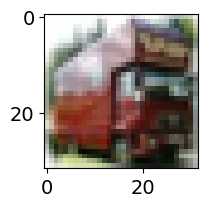

Label: 9


In [12]:
cifar_plot_image_and_label(test_loader_nn) # re-evaluate cell if you get a long debugging text

In [13]:
train_loader_cf, valid_loader_cf = cifar_data_loader(data_dir=cifar_dir,
                                         batch_size=64)

test_loader_cf = cifar_data_loader(data_dir=cifar_dir,
                              batch_size=64,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
print_features(train_loader_cf)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


In [15]:
print_features(valid_loader_cf)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


### Define a simple CNN

### 3 linear layers (LL), 
- Initial dimension corresponds to the convolutional array flattened array
- Final dimension corresponds to number of CIFAR features (10)

In [22]:
LLYR=[]
LLYR.append(LinealLayerPars(512, 256))
LLYR.append(LinealLayerPars(256, 128))
LLYR.append(LinealLayerPars(128, 10))
llyrs = build_linear_layers(LLYR, df=0.25)

In [23]:
print(llyrs)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Dropout(p=0.25, inplace=False)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)


### Convolutional Layers
- 5 layers increasing features from 3 to 128 while reducing dimension of input image (32 x 32)

In [24]:
CL = []
c1 = Conv2dPars(in_channels=3, out_channels=32, kernel_size=3, padding=1)
c2 = Conv2dPars(in_channels=32, out_channels=64, kernel_size=3, padding=1)
c3 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
c4 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=3, padding=1)
c5 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=3, padding=1)
p2d = MaxPool2dPars(kernel_size=2, stride=2)
CL.append(build_conv_layer(c1, p2d, relu='standard'))
CL.append(build_conv_layer(c2, p2d, relu='standard'))
CL.append(build_conv_layer(c3, p2d, relu='standard'))
CL.append(build_conv_layer(c4, p2d, relu='standard'))
CL.append(build_conv_layer(c5, p2d, relu='standard'))
clyrs = build_conv_layers(CL)

In [25]:
print(clyrs)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=

### cnn evaluation shows the final dimension of the flattened array to be 512

In [26]:
cnn_evaluation(torch.randn(1,3,32,32), CL)

shape of input image = torch.Size([1, 3, 32, 32])
 after cl = 1, shape of out image = torch.Size([1, 32, 16, 16])
 after cl = 2, shape of out image = torch.Size([1, 64, 8, 8])
 after cl = 3, shape of out image = torch.Size([1, 128, 4, 4])
 after cl = 4, shape of out image = torch.Size([1, 256, 2, 2])
 after cl = 5, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [27]:
model = CNN(clyrs,llyrs).to(device)

In [28]:
print(model)

CNN(
  (conv_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), 

In [29]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 4, 4]         295,168
      BatchNorm2d-14            [-1, 25

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


### Run the CNN

In [31]:
x_single_run(train_loader_cf, device, model, optimizer, criterion, xc=True)

** Run for 1 event**
epoch = 0
i = 0
labels shape = torch.Size([64])
imgs shape = torch.Size([64, 3, 32, 32])
labels = tensor([8, 3, 2, 7, 1, 2, 2, 5, 7, 9, 4, 6, 3, 4, 6, 3, 1, 9, 7, 7, 3, 9, 5, 8,
        4, 1, 9, 1, 2, 8, 3, 8, 1, 1, 2, 6, 0, 4, 6, 3, 7, 8, 9, 4, 1, 8, 6, 5,
        8, 3, 3, 7, 1, 9, 1, 2, 6, 5, 2, 7, 4, 0, 1, 8])
outputs = torch.Size([64, 10])
predicted label = tensor([2, 0, 7, 1, 1, 1, 2, 2, 5, 4, 4, 4, 5, 4, 0, 4, 4, 4, 2, 7, 4, 1, 4, 3,
        1, 5, 2, 4, 1, 5, 1, 2, 4, 9, 2, 5, 3, 7, 1, 5, 4, 2, 3, 5, 2, 2, 1, 4,
        2, 2, 1, 5, 1, 3, 2, 2, 5, 4, 2, 4, 4, 4, 5, 2], device='cuda:0')
correct = 10
Train Step 1/704, Loss: 2.295025587081909
i = 1
labels shape = torch.Size([64])
imgs shape = torch.Size([64, 3, 32, 32])
labels = tensor([5, 3, 3, 0, 7, 5, 7, 4, 9, 6, 4, 6, 5, 4, 9, 9, 6, 8, 2, 5, 8, 0, 7, 0,
        1, 7, 4, 6, 5, 7, 9, 2, 4, 2, 1, 8, 9, 4, 1, 7, 5, 3, 7, 8, 9, 9, 1, 6,
        1, 7, 5, 4, 5, 4, 9, 3, 1, 8, 9, 3, 8, 4, 6, 5])
outputs = torch.Size(

In [32]:
train_losses, val_losses, acc = x_train_cnn(train_loader_cf, valid_loader_cf, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->45056 images
size of train loader  ->704 images
Evaluating with  ->5056 images
size of eval loader  ->79 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 0 AVG TRAIN LOSS: 1.3200126198882407
--- EPOCH 0 AVG VAL LOSS: 1.091178596774234
Accuracy on the 79 validation images: 61.2 %

EPOCH 1
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 1 AVG TRAIN LOSS: 0.9152683004821566
--- EPOCH 1 AVG VAL LOSS: 0.828310524361043
Accuracy on the 79 validation images: 70.58 %

EPOCH 2
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 2 AVG TRAIN LOSS: 0.755453472406688
--- EPOCH 2 AVG VAL LOSS: 0.7874143632906901
Accuracy on the 79 validation images: 72.5 %

EPOCH 3
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 3 AVG TRAIN LOSS: 0.6455053849653765
--- EPOCH 3 AVG VAL LOSS: 0.6876596778253966
Accuracy on

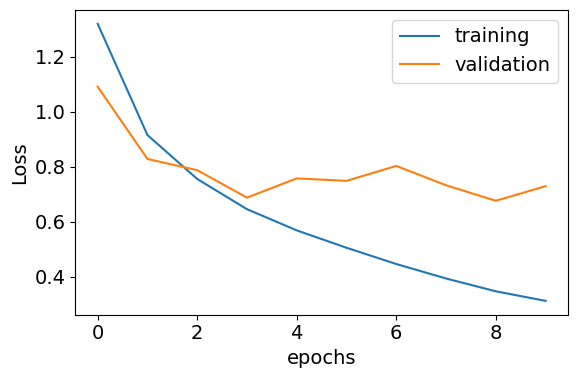

In [33]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

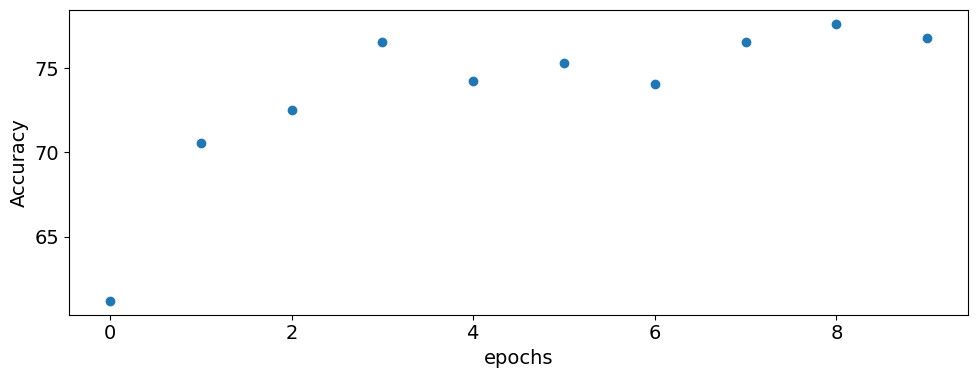

In [34]:
plot_accuracy(acc,figsize=(10, 4))

## RESNET

In [35]:
model = ResNet10(ResBlock, in_channels=3, out_channels=32, num_classes = 10, dropout_fraction=0.2, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 32,  blocks = 1, stride = 1
 ## make_layer: in_planes=32
 ## make_layer: downsample = None
 ## make_layer 2: planes = 64,  blocks = 1, stride = 2
 ## make_layer: in_planes=32
 ## make_layer: downsample = Sequential(
  (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 5: planes = 512,  blocks = 1, stride = 2
 ## m

In [36]:
model(torch.randn(1,3,32,32).to(device))

 ResNet10: input data shape =>torch.Size([1, 3, 32, 32])
 ResNet10: after conv1 =>torch.Size([1, 32, 32, 32])
 ResNet10: after layer0 =>torch.Size([1, 32, 32, 32])
 ResNet10: after layer1 =>torch.Size([1, 64, 16, 16])
 ResNet10: after layer2 =>torch.Size([1, 128, 8, 8])
 ResNet10: after layer3 =>torch.Size([1, 256, 4, 4])
 ResNet10: after layer4 =>torch.Size([1, 512, 2, 2])
 ResNet10: after avgpool =>torch.Size([1, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([1, 512])
 ResNet10: after fc =>torch.Size([1, 10])


tensor([[ 1.1095,  0.1591,  0.8062,  0.3907,  0.0496, -0.3695,  2.1298,  0.1924,
         -2.6503,  0.2389]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [37]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,248
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
         ResBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 16, 16]          18,496
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [38]:
optimizer= optim.Adam(model.parameters(), lr=0.001)

In [39]:
train_losses, val_losses, acc = x_train_cnn(train_loader_cf, valid_loader_cf, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->45056 images
size of train loader  ->704 images
Evaluating with  ->5056 images
size of eval loader  ->79 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 0 AVG TRAIN LOSS: 1.3921513890170238
--- EPOCH 0 AVG VAL LOSS: 1.0740049126781994
Accuracy on the 79 validation images: 61.14 %

EPOCH 1
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 1 AVG TRAIN LOSS: 0.8947163828733292
--- EPOCH 1 AVG VAL LOSS: 0.7720056760914719
Accuracy on the 79 validation images: 72.14 %

EPOCH 2
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 2 AVG TRAIN LOSS: 0.6726820890114389
--- EPOCH 2 AVG VAL LOSS: 0.7690745346908328
Accuracy on the 79 validation images: 71.9 %

EPOCH 3
training step: size of sample 704
Validation step: size of sample 79
--- EPOCH 3 AVG TRAIN LOSS: 0.5192088960796933
--- EPOCH 3 AVG VAL LOSS: 0.6519380215602585
Accurac

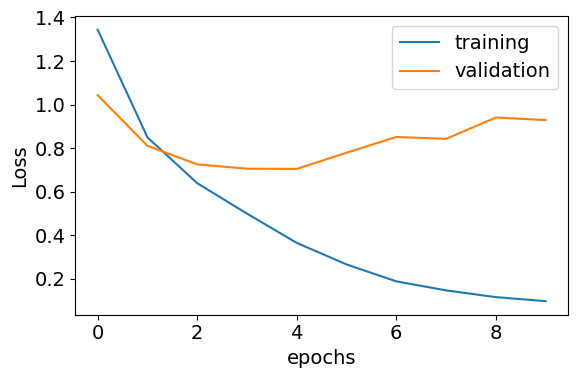

In [71]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

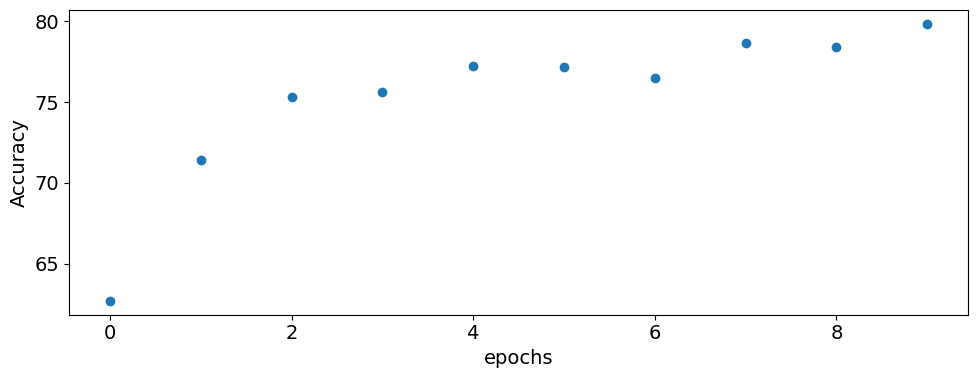

In [72]:
plot_accuracy(acc,figsize=(10, 4))